# Problem Set 4 - Structural Estimation

## John Wilson
### July 15, 2017

In [1]:
import numpy as np
import scipy.stats as sts
from scipy.special import gamma, beta
from matplotlib import pyplot as plt
import scipy.optimize as opt
import scipy.integrate as integrate
%matplotlib notebook

## Problem 1

In [2]:
data = np.loadtxt("data/clms.txt")

### Part a)

In [3]:
mean = np.mean(data)
median = np.median(data)
maximum = np.amax(data)
minimum = np.amin(data)
std_dev = np.std(data)
print("The data had the following parameters:\n \
    Mean:\t\t{}\n \
    Median:\t\t{}\n \
    Maximum:\t\t{}\n \
    Minimum:\t\t{}\n \
    Standard Dev.:\t{}".format(mean, median, maximum, minimum, std_dev))

The data had the following parameters:
     Mean:		720.2779753272437
     Median:		172.21
     Maximum:		227967.25
     Minimum:		0.01
     Standard Dev.:	3972.663756393663


<IPython.core.display.Javascript object>


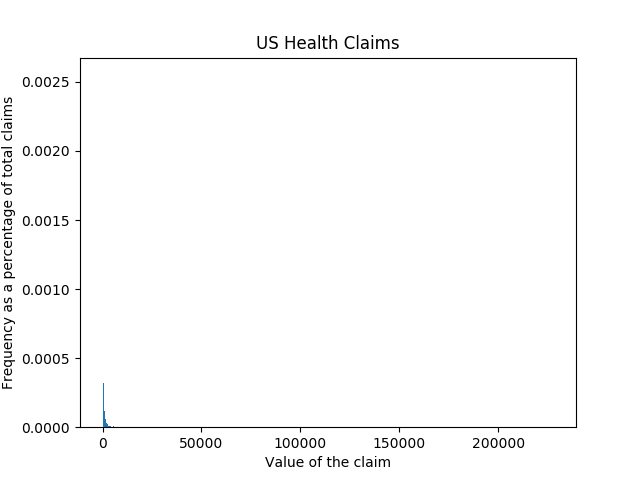

In [4]:
plt.hist(data, bins = 1000, normed = True)
plt.title("US Health Claims")
plt.xlabel("Value of the claim")
plt.ylabel("Frequency as a percentage of total claims")
plt.show()

<IPython.core.display.Javascript object>


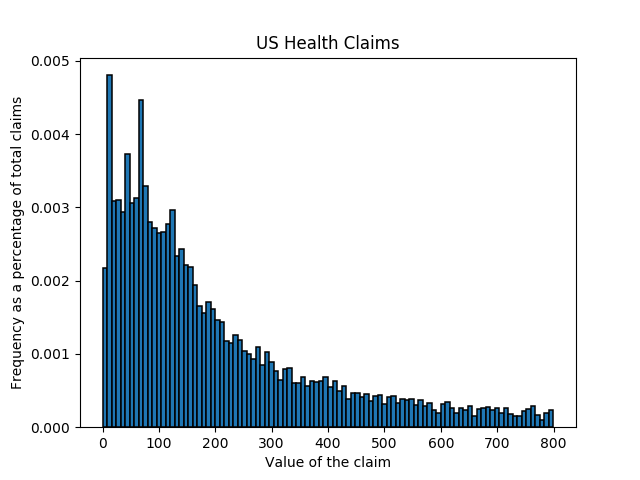

In [5]:
small = data[data<=800]
weights = np.ones(len(small)) / len(data) / 7.996 # This is the bin width for 100 bins
count, bins, ignored = plt.hist(small, 100, weights=weights, edgecolor='black',
    linewidth=1.1)
plt.title("US Health Claims")
plt.xlabel("Value of the claim")
plt.ylabel("Frequency as a percentage of total claims")

The second one is preferable because it gives a more readable view of the chunk of the data with the highest density. You lose some high values of insurance claims in exchange for more detail on the big chunk of them. The first histogram is almost unreadable.

### Part b)

In [6]:
# Create a function to work the gamma distribution
def gamma_pdf(xvals, alpha, beta):
    G = gamma(alpha)
    return xvals ** (alpha - 1) * np.exp(-xvals / beta) / (G * beta ** alpha)

def log_lik_gamma(xvals, alpha, beta):
    pdf_vals = gamma_pdf(xvals, alpha, beta)
    ln_pdf_vals = np.log(pdf_vals)
    return ln_pdf_vals.sum()

def crit(params, xvals):
    alpha, beta = params
    return -1 * log_lik_gamma(xvals, alpha, beta)

In [7]:
beta_init = std_dev ** 2 / mean
alpha_init = mean / beta_init
params_init = np.array([alpha_init, beta_init])
results = opt.minimize(crit, params_init, args=data,
                       method = 'L-BFGS-B', bounds = ((1e-10, None), (1e-10, None)))
alpha_MLE, beta_MLE = results.x
likelihood_MLE = -results.fun
print('alpha_MLE=', alpha_MLE, ' beta_MLE=', beta_MLE)
print("Function value: ", likelihood_MLE)

alpha_MLE= 0.221755309875  beta_MLE= 21911.0646993
Function value:  -82076.4516057


<IPython.core.display.Javascript object>


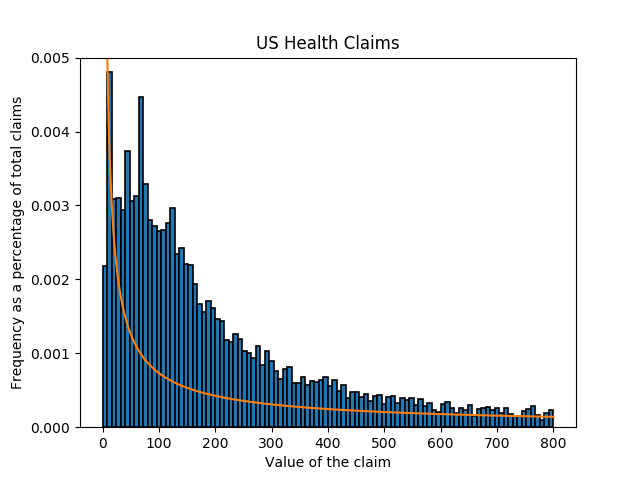

In [8]:
count, bins, ignored = plt.hist(small, 100, weights=weights, edgecolor='black',
    linewidth=1.2)
dom = np.linspace(1e-10,800,1000)
plt.plot(dom, gamma_pdf(dom, alpha_MLE, beta_MLE))
plt.ylim(0,0.005)
plt.title("US Health Claims")
plt.xlabel("Value of the claim")
plt.ylabel("Frequency as a percentage of total claims")

### Part c)

In [9]:
# Create a function to work the gamma distribution
def gen_gamma_pdf(xvals, a, b, m):
    G = gamma(a/m)
    power = -1 * (xvals / b) ** m
    return m * xvals ** (a - 1) * np.exp(power) /\
            (G * b ** a)

def log_lik_gen_gamma(xvals, alpha, beta, m):
    pdf_vals = gen_gamma_pdf(xvals, alpha, beta, m)
    ln_pdf_vals = np.log(pdf_vals)
    return ln_pdf_vals.sum()

def crit_gen(params, xvals):
    alpha, beta, m = params
    return -1 * log_lik_gen_gamma(xvals, alpha, beta, m)

In [10]:
beta_init = beta_MLE
alpha_init = alpha_MLE
m_init = 2.0
params_init = np.array([alpha_init, beta_init, m_init])
results = opt.minimize(crit_gen, params_init, args=data,
                       method = 'L-BFGS-B', 
                       bounds = ((1e-10, None), (1e-10, None), (1e-10, None)))
alpha_MLE_GG, beta_MLE_GG, m_MLE_GG = results.x
likelihood_MLE_GG = -results.fun
print('alpha_MLE=', alpha_MLE_GG, ' beta_MLE=', beta_MLE_GG, ' m_MLE=', m_MLE_GG)
print("Function value: ", likelihood_MLE_GG)

alpha_MLE= 0.221756017794  beta_MLE= 21911.0272029  m_MLE= 0.997681093989
Function value:  -82076.4430627


<IPython.core.display.Javascript object>


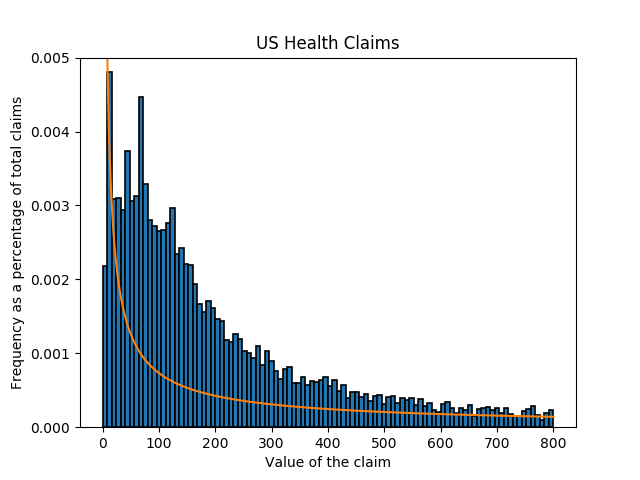

In [11]:
count, bins, ignored = plt.hist(small, 100, weights=weights, edgecolor='black',
    linewidth=1.2)
dom = np.linspace(1e-10,800,1000)
plt.plot(dom, gen_gamma_pdf(dom, alpha_MLE, beta_MLE, m_MLE_GG))
plt.ylim(0,0.005)
plt.title("US Health Claims")
plt.xlabel("Value of the claim")
plt.ylabel("Frequency as a percentage of total claims")

### Part d)

In [12]:
# Create a function to work the gamma distribution
def gen_beta_pdf(xvals, a, b, p, q):
    B = beta(p,q)
    """
    denom = (1 + (xvals / b) ** a)
    argument = (a*p-1)*np.log(xvals)+np.log(a)-a*p*np.log(b)-np.log(B)-(p+q)*np.log(denom)
    return np.exp(argument)
    """    
    denom = (1 + (xvals / b) ** a) ** (p + q)
    return a * xvals ** (a * p - 1) / (b ** (a * p) * B * denom)

def log_lik_gen_beta(xvals, a, b, p, q):
    pdf_vals = gen_beta_pdf(xvals, a, b, p, q)
    ln_pdf_vals = np.log(pdf_vals)
    return ln_pdf_vals.sum()

def crit_gen_b(params, xvals):
    a, b, p, q = params
    return -1 * log_lik_gen_beta(xvals, a, b, p, q)

In [13]:
a_init = m_MLE_GG
p_init = alpha_MLE_GG / m_MLE_GG
q_init = 10000
b_init = (q_init ** (1 / m_MLE_GG)) * beta_MLE_GG
params_init = np.array([a_init, b_init, p_init, q_init])
results = opt.minimize(crit_gen_b, params_init, args=data,
                       method = 'L-BFGS-B', 
                       bounds = ((1e-10, None), (1e-10, None), (1e-10, None), (1e-10, None)))
a_MLE, b_MLE, p_MLE, q_MLE = results.x
likelihood = -results.fun
print('a_MLE=',a_MLE,'\nb_MLE=',b_MLE,'\np_MLE=',p_MLE,'\nq_MLE=',q_MLE)
print("Function value:", -results.fun)

a_MLE= 0.815129781237 
b_MLE= 223851454.898 
p_MLE= 0.365295212605 
q_MLE= 9999.9991394
Function value: -78420.0435152


C:\Users\John\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in power
  if __name__ == '__main__':
C:\Users\John\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
C:\Users\John\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


<IPython.core.display.Javascript object>


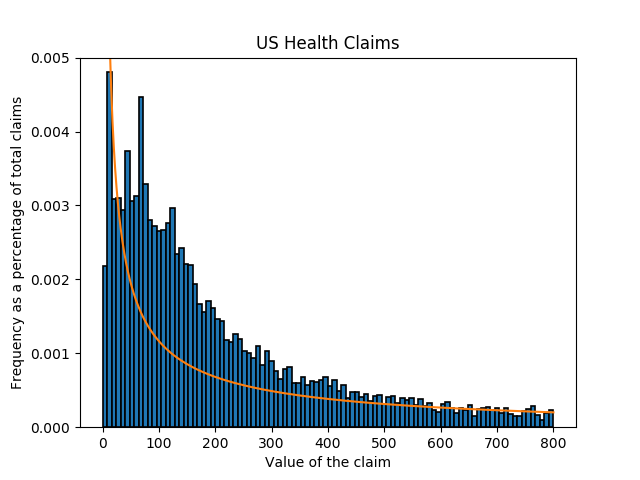

In [14]:
count, bins, ignored = plt.hist(small, 100, weights=weights, edgecolor='black',
    linewidth=1.2)
dom = np.linspace(1e-10,800,1000)
plt.plot(dom, gen_beta_pdf(dom, a_MLE, b_MLE, p_MLE, q_MLE))
plt.ylim(0,0.005)
plt.title("US Health Claims")
plt.xlabel("Value of the claim")
plt.ylabel("Frequency as a percentage of total claims")

### Part e)

In [15]:
# Test the Gamma distribution
LR_val = 2 * (likelihood - likelihood_MLE)
pval_h0 = 1.0 - sts.chi2.cdf(LR_val, 2)
print('chi squared of gamma values with 2 degrees of freedom p-value = ', pval_h0)

# Testing the Generalized Gamma distribution
LR_val = 2 * (likelihood - likelihood_MLE_GG)
pval_h0 = 1.0 - sts.chi2.cdf(LR_val, 3)
print('chi squared of generalized gamma values with 2 degrees of freedom p-value = ', pval_h0)

chi squared of gamma values with 2 degrees of freedom p-value =  0.0
chi squared of generalized gamma values with 2 degrees of freedom p-value =  0.0


We reject the null hypotheses that the data was obtained from a beta distribution with the parameters derived through maximum likelihood testing on the gamma and generalized gamma distributions.

### Part f)

In [16]:
prob1 = integrate.quad(gamma_pdf, 1000, np.inf, args=(alpha_MLE, beta_MLE))[0]
prob2 = integrate.quad(gen_gamma_pdf, 1000, np.inf, args = (alpha_MLE_GG, beta_MLE_GG, m_MLE_GG))[0]
print("The probability derived from the gamma distribution is {}".format(prob1))
print("The probability derived from the generalized gamma distribution is {}".format(prob2))
print("This amount changes by {}".format(abs(prob1-prob2)))

The probability derived from the gamma distribution is 0.4519597243652706
The probability derived from the generalized gamma distribution is 0.4519274821498008
This amount changes by 3.224221546982431e-05
